# importing the libraries
                                                                                                            @satyam shivam

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from  tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator, array_to_img

import os
import random

# importing the csv file and exploring it

In [2]:
df = pd.read_csv("english.csv")
df.head()


,image,label
0,Img/img001-001.png,0
1,Img/img001-002.png,0
2,Img/img001-003.png,0
3,Img/img001-004.png,0
4,Img/img001-005.png,0


In [3]:
df.describe()

,image,label
count,3410,3410
unique,3410,62
top,Img/img034-051.png,8
freq,1,55


#Fetching the classes

In [4]:
classes = df.label.unique()
print(f"{len(classes)} Classes are : {classes}")

62 Classes are : ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


#exploring images

In [5]:
dataPath = os.getcwd() + "//Img"

def remove_preceding(col):
  return col[4:]

df['image'] = df['image'].apply(remove_preceding)

df.image[:5]

0    img001-001.png
1    img001-002.png
2    img001-003.png
3    img001-004.png
4    img001-005.png
Name: image, dtype: object

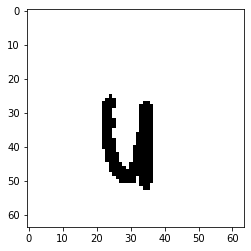

In [6]:
# lets take a look at one of the images randomly
index = random.randrange(len(df))
img = load_img(dataPath + "//" + df.at[index, 'image'], target_size = (64,64))
plt.imshow(img)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


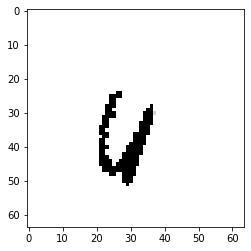

In [7]:
#now lets augment this image with rotation
augmented_image_generator = ImageDataGenerator(rotation_range = 180)

# convert the img from 3 to 4 dimensions, including the number of samples column
# our img is of (64,64,3) shape
temp_arr = img_to_array(img)
temp_arr = temp_arr.reshape(1, temp_arr.shape[0], temp_arr.shape[1], temp_arr.shape[2])

aug_data = augmented_image_generator.flow(temp_arr, batch_size = 1)

plt.imshow(aug_data[0][0])

In [8]:
#check if the label of that image matches the image itself
df.at[index, 'label']

'u'

#Creating Validation and Testing datasets

In [9]:
# we have our main dataFrame 'df' that we will work with
# now to create the training, validation, testing array

validation_length = int(len(df) * 0.25) # 25 % of whole
testing_length = int(validation_length * 0.1) # 10 % of valdation
# And the remaining is for the training

validation_data_list = random.sample(range(len(df)), validation_length)
validation_df = pd.DataFrame(df.iloc[validation_data_list].values, columns = ['image', 'label'])
df.drop(validation_data_list, axis = 0, inplace = True)

testing_data_list = random.sample(range(len(validation_df)), testing_length)
testing_df = pd.DataFrame(validation_df.iloc[testing_data_list].values, columns = ['image','label'])
validation_df.drop(testing_data_list, axis = 0, inplace = True)

training_data = df[:].values

training_df = pd.DataFrame(training_data, columns = ['image','label'])

#taking a quick look to all three dataFrames 

In [10]:
training_df.head()

,image,label
0,img001-001.png,0
1,img001-003.png,0
2,img001-008.png,0
3,img001-009.png,0
4,img001-011.png,0


In [11]:
testing_df.head()

,image,label
0,img015-049.png,E
1,img059-038.png,w
2,img053-006.png,q
3,img059-027.png,w
4,img050-032.png,n


In [12]:
validation_df.head()

,image,label
0,img061-032.png,y
1,img015-042.png,E
2,img033-040.png,W
3,img034-032.png,X
4,img028-015.png,R


#Augmentating data

In [13]:
training_data_augmentor = ImageDataGenerator(
    rescale = 1/255,
    shear_range = 0.14,
    zoom_range = 0.14,
    width_shift_range = 0.14,
    height_shift_range = 0.14
)

data_augmentor = ImageDataGenerator(rescale = 1/255)

# for testing
dataFrame_training = training_data_augmentor.flow_from_dataframe(
    dataframe = training_df,
    directory = dataPath,
    x_col = 'image',
    y_col = 'label',
    target_size = (64,64),
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

#for validation
dataFrame_validation = data_augmentor.flow_from_dataframe(
    dataframe = validation_df,
    directory = dataPath,
    x_col = 'image',
    y_col = 'label',
    target_size = (64,64),
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

#for testing
dataFrame_testing = data_augmentor.flow_from_dataframe(
    dataframe = testing_df,
    directory = dataPath,
    x_col = 'image',
    y_col = None,
    target_size = (64,64),

    color_mode = 'grayscale',
    class_mode = None
)

Found 2558 validated image filenames belonging to 62 classes.
Found 767 validated image filenames belonging to 62 classes.
Found 85 validated image filenames.


#Model Creation and fitting

In [14]:
model = tf.keras.models.Sequential()
model.add(BatchNormalization())

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding='same', input_shape = (64,64,1), activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.25))

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding='same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.25))

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding='same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.25))

model.add(Flatten())

model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(units = 62, activation = 'softmax'))

In [15]:
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [16]:
history = model.fit(dataFrame_training, epochs = 10, validation_data = dataFrame_validation)

Epoch 1/10
80/80 [==============================] - 81s 997ms/step - loss: 4.1301 - accuracy: 0.0152 - val_loss: 4.1275 - val_accuracy: 0.0091
Epoch 2/10
80/80 [==============================] - 70s 871ms/step - loss: 4.0841 - accuracy: 0.0309 - val_loss: 4.0671 - val_accuracy: 0.0639
Epoch 3/10
80/80 [==============================] - 70s 870ms/step - loss: 3.8730 - accuracy: 0.0676 - val_loss: 3.6928 - val_accuracy: 0.1721
Epoch 4/10
80/80 [==============================] - 72s 897ms/step - loss: 3.3983 - accuracy: 0.1411 - val_loss: 2.8700 - val_accuracy: 0.2986
Epoch 5/10
80/80 [==============================] - 70s 876ms/step - loss: 2.8848 - accuracy: 0.2373 - val_loss: 2.1565 - val_accuracy: 0.4524
Epoch 6/10
80/80 [==============================] - 70s 873ms/step - loss: 2.4168 - accuracy: 0.3393 - val_loss: 1.7695 - val_accuracy: 0.5463
Epoch 7/10
80/80 [==============================] - 81s 1s/step - loss: 2.0988 - accuracy: 0.3851 - val_loss: 1.2699 - val_accuracy: 0.6076
Ep

#Visualizing how the accuracy and loss changed in each epoch for training and validation

In [17]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Training and Validation loss')

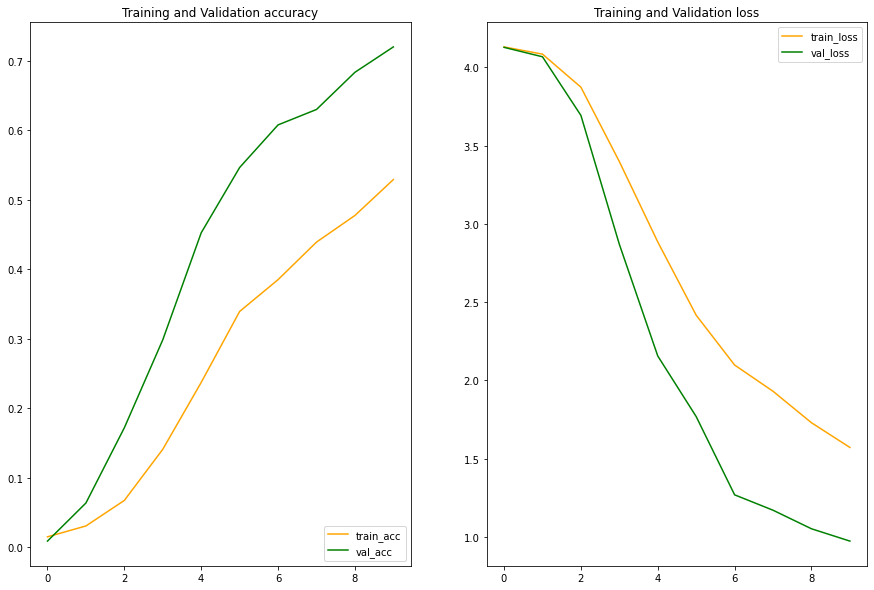

In [19]:
acc = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(10)

plt.figure(figsize = (15,10))

plt.subplot(1,2,1)
plt.plot(epochs, acc, color = 'orange')
plt.plot(epochs, val_accuracy, color = 'green')
plt.legend(['train_acc', 'val_acc'], loc = 'lower right')
plt.title("Training and Validation accuracy")

plt.subplot(1,2,2)
plt.plot(epochs, loss, color = 'orange')
plt.plot(epochs, val_loss, color = 'green')
plt.legend(['train_loss', 'val_loss'], loc=  'upper right')
plt.title("Training and Validation loss")

#Prediction

In [20]:
pred = model.predict(dataFrame_testing)

outputdf = pd.DataFrame(pred)

# lets consider first 10 predicted images and display them
maxIndex = list(outputdf[:10].idxmax(axis = 1))

print("MaxIndexes : {}".format(maxIndex))

# the following are the 62 classes with their indices from training dataframe created from Augmented cell
print("Class - indicies : {}".format(dataFrame_training.class_indices))



MaxIndexes : [56, 12, 44, 37, 4, 48, 8, 38, 19, 48]
Class - indicies : {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35, 'a': 36, 'b': 37, 'c': 38, 'd': 39, 'e': 40, 'f': 41, 'g': 42, 'h': 43, 'i': 44, 'j': 45, 'k': 46, 'l': 47, 'm': 48, 'n': 49, 'o': 50, 'p': 51, 'q': 52, 'r': 53, 's': 54, 't': 55, 'u': 56, 'v': 57, 'w': 58, 'x': 59, 'y': 60, 'z': 61}


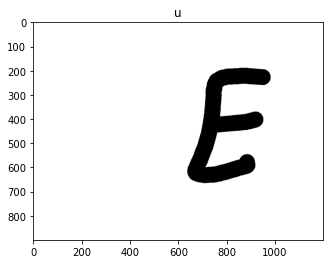

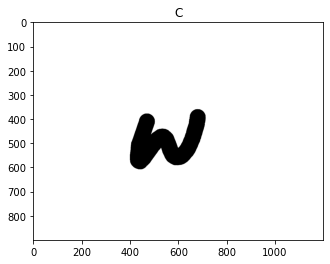

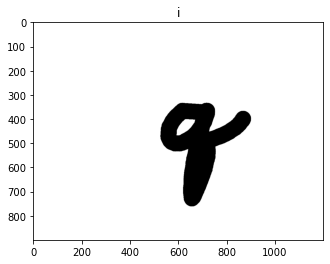

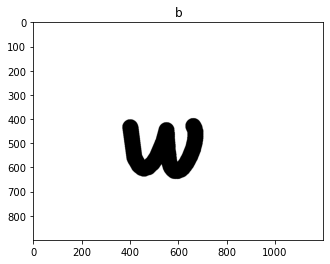

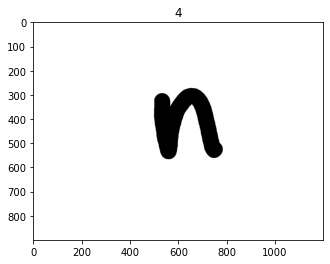

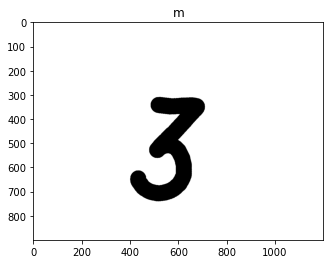

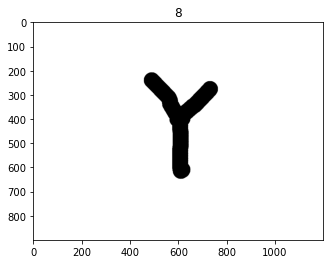

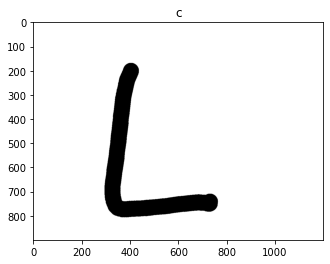

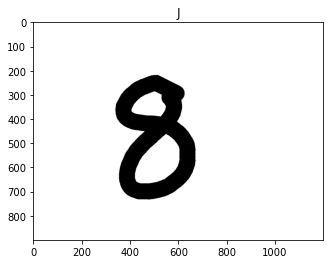

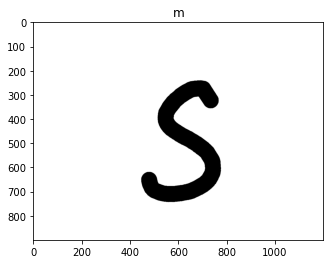

In [21]:
for i in range(10):
  img = load_img(dataPath + "//" + testing_df.at[i, 'image'])  # testing_df from "Creating training and Validation dataset"
  plt.title(classes[maxIndex[i]])
  plt.imshow(img)
  plt.show()